## 1. Questions

Our group's overall objective was to apply different ways of classifying documents into either horror or non-horror. First, we used two different methods(cosine similarity, supervised learning) to confirm that horror documents are actually distinctive from non-horror documents. Under the assumption that documents are classsifiable, we wanted to recognize that horror and non-horror documents are different in terms of usage of words. Before performing the analysis, we came up with the hypothesis that words that are commonly used throughout any set of texts like "the", "a", "of", "he", "she", "they", etc would not show significant difference between the two genres. We also expected that words like "upon", "do", and "it" to be more prevalent in horror texts compared to non-horror texts because expressions like "the ghost came upon him", "just do it!", "It (the ghost) is following me!" are some examples of lines we thought we would read in a horror text more than non-horror texts.

## 2. Methods

### (a) Cosine Similarity Analysis

Cosine similary measures the cosine angle between two non-zero vectors. Consine similarity equals to "1" when the angle equals to "0"; with respect to this project, cosine similarity of two identical documents will equal to "1" since there will be no difference in usage of words. As the angle increases between vectors(different documents are being compared), cosine similarity will decrease from the value of "1". 

The funciton "compare_documents" calculates cosine similarity for each document with respect to the function's input document and returns a sorted list of all documents in a descending order. For each horror documents, we first print out top 5 documents (excluding the document at index "0" since that document is identical to the input with cosine similarity of "1.0") that are considered to have high cosine similarity with the query document. In order to check the accuracy of this analysis, we create a Counter object for the purpose of keeping track of the number of documents that are also recorded as horror and have high cosine similarity with the input of the function. If the majority among 5 documents are indeed horror-related, we add 1 to the variable "accuracy", and overall accuracy is calculated in a percentage term by dividing the variable "accuracy" by the total number of horror documents. Same process is conducted for bottom 5 documents, but we add 1 to the variable "accuracy" when the majority among 5 documents are non-horror. 

### (b) Supervised Learning (Naive Bayes, Logistic Regression)

Since we are given *Horror?* column in the metadata file, which corresponds to the label space $\{TRUE, FALSE\}$. Using 147 samples (81 non-horrors and 67 horrors), we randomly shuffle a training set (75\%) and test set (25\%) such that  the number of horrors for each set is unbiased. Futhermore, we train our model using ensemble (`sklearn.ensemble.VotingClassifier`) with logistic regression and Naive Bayes to predict the final label. Both classifiers are pitted against each other and selected upon best performance by voting [[1]](https://towardsdatascience.com/ensemble-learning-in-machine-learning-getting-started-4ed85eb38e00)  Once we obtiain this ensemble classifier, we perform 3-fold cross-validation to observe consistency.

#### Feature Engineering
Here, we only use two features from the text itself. Note that we use `CountVectorizer` and `TfidfTransformer` from `sklearn.feature_extraction.text`. The first counts the occurences of each token. The defined `Tokenizer` class calls spacy's default tokenization with lemmatization, which is the process of grouping together the inflected forms of a word so they can be analysed as a single item (e.g., "affected", "affects" $\to$ "affect").[[2]](https://medium.com/@makcedward/nlp-pipeline-lemmatization-part-3-4bfd7304957) For consistency, we stick to counting the lemmatized tokens.

The second feature is tf-idf scores. Since we are training a classifier to determine a specific genre, we may want to find tokens that are informative than the enumerating frequent raw tokens. The goal of using tf-idf is to scale down the impact of frequent tokens and to scale up specific tokens that occur less frequent in a small fraction of the training corpus.

#### Comments on Hyperparameter Tuning
Notice that there are many hyperparameters involved in the code. For instance, we may set up parameters for classifiers (`MultinomialNB()`, `LogisticRegression())` or parameters for features (`CountVectorizer()`, `TfidfTransformer()`) Instead of performing greedy search for hyperparameter tuning, we use default values in this project to avoid overfitting. For experiment purpose, we implemented `LogisticRegressionCV`, which performs hyperparameter search within the training, instead of `LogisticRegression` with default parameters. The algorithm resulted in very high training accuracy without changing much test accuracy. This may be a bad instance of overfitting because the dataset is relatively small with sparse feature matrix. 

### (c) Z-Score Analysis (Heat Map)

To measure if there is a salient difference of usage in words between the horror and non-horror documents in the collection, we perform Z-score analysis we previously covered in class and visualizing the difference in the scores between the two genres in histogram for comparing individual words and heat map for comparing multiple words. The z score of a word will be calculatd by taking the probability of the word occuring in the text that it's in and subtracting by the mean probabilty of the word occuring across documents and dividing by the standard deviation of the probability of words across documents. This output is related to the question stated above because the difference in mean z scores of a particular word shows if the word is used more frequently used by texts in either horror or non-horror genre. 

## 3. Code

In [25]:
import csv, sys, os, re
from collections import Counter
import numpy as np
from imblearn.pipeline import Pipeline as Pipeline_imb # Requires imblearn package 
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.ensemble import VotingClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split, ShuffleSplit
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import MaxAbsScaler
import spacy
word_pattern = re.compile("\w[\w\-\']*\w|\w")

In [2]:
documents = []

with open("data/Gutenberg-2019-10-21/metadata.csv", encoding="utf-8") as reader:
    csv_reader = csv.DictReader(reader)
    for document in csv_reader:
        try:
            with open("data/Gutenberg-2019-10-21/{}".format(document["Filename"]), encoding="utf-8") as reader:
                print(document["Author"] + " / " + document["Title"])

                lines = []
                for line in reader:
                    lines.append(line.rstrip())

                text = " ".join(lines)
                document["Text"] = text
                document["Tokens"] = word_pattern.findall(text)
                
                documents.append(document)
        except Exception as e:
            print("! Problem with {}: {}".format(document["Filename"], e))

Alcott, Louisa May / Eight Cousins
Austen, Jane / Persuasion
Austen, Jane / Sense and Sensibility
Austen, Jane / Emma
Austen, Jane / Pride and Prejudice
Baring-Gould, Sabine / The Book of Were-Wolves
Barrie, J.M. / Peter Pan
Baum, Lyman Frank / Glinda of Oz
Baum, Lyman Frank / The Wonderful Wizard of Oz
Baum, Lyman Frank / The Lost Princess
Beckford, William / Vathek
Bierce, Ambrose / The Damned Thing
Bierce, Ambrose / An Occurrence at Owl Creek Bridge
Bierce, Ambrose / The Parenticide Club
Bierce, Ambrose / Present at a Hanging and Other Ghost Stories
Birkhead, Edith / The Tale of Terror
! Problem with edith_the_tale_of_terror_pg14154.txt: 'utf-8' codec can't decode byte 0xe9 in position 6657: invalid continuation byte
Blackwood, Algernon / The Willows
Blackwood, Algernon / The Damned
Blackwood, Algernon / Four Weird Tales
Blackwood, Algernon / Day and Night Stories
Blackwood, Algernon  / The Wendigo
Blake, William  / Songs of Innocence and of Experience
Blanchard, Amy Ella / A Sweet 

In [3]:
all_counts = Counter()

for document in documents:
    doc_counter = Counter(document["Tokens"])
    all_counts += doc_counter   
    document["TokenCounts"] = doc_counter

all_counts.most_common(15)

[('the', 623845),
 ('and', 356326),
 ('of', 333712),
 ('to', 310776),
 ('a', 240764),
 ('I', 211323),
 ('in', 179070),
 ('was', 154410),
 ('that', 152156),
 ('he', 126231),
 ('it', 119953),
 ('his', 112175),
 ('had', 98968),
 ('you', 98895),
 ('with', 93888)]

In [4]:
print("# of documents:", len(documents))
print("# of horrors:", len([doc for doc in documents if doc["Horror?"] == 'TRUE']))
print("# of non-horrors:", len([doc for doc in documents if doc["Horror?"] == 'FALSE']))

# of documents: 148
# of horrors: 67
# of non-horrors: 81


In [5]:
genre_list = np.array([doc["Genre"] for doc in documents])

In [6]:
horror_genre=[]
for document in documents: 
    if document["Horror?"] == "TRUE":
        horror_genre.append(document["Genre"])

### (a) Cosine Similarity 

In [7]:
vocabulary = [w for w, c in all_counts.most_common()]

vocabulary_size = len(vocabulary)
reverse_vocab = { w: i for i, w in enumerate(vocabulary) }

In [8]:
def counter_to_vector(counter):
    vector = np.zeros(vocabulary_size)
    for word in counter.keys():
        ## look up the integer ID for the string *if* it has one
        if word in reverse_vocab:
            word_id = reverse_vocab[word]
            vector[word_id] = counter[word]
    
    return vector

In [9]:
all_vector = counter_to_vector(all_counts)

for document in documents:
    document["Vector"] = counter_to_vector(document["TokenCounts"])

In [10]:
def cosine(a, b):
    norm_a = np.linalg.norm(a)
    norm_b = np.linalg.norm(b)
    
    return a.dot(b) / (norm_a * norm_b)

In [11]:
def compare_documents(query_doc, similarity_function):
    comparisons = [("{:.3f}".format(similarity_function(query_doc["Vector"], document["Vector"])), 
                    document["Title"], document["Year"], document["Horror?"])
                   for document in documents]
    return sorted(comparisons, reverse=True)

In [12]:
##for each document classified as "Horror", print out top 5 documents with high cosine similarity,
##and check if their genres are also "Horror"

accuracy_1 = 0
for doc_id, document in enumerate(documents):
    if document["Horror?"] == "TRUE":
        print(doc_id, document["Title"], document["Genre"])
        print(compare_documents(documents[doc_id],cosine)[1:6])
        similarity_1 = []
        is_horror_1 = Counter()
        for i in compare_documents(documents[doc_id],cosine)[1:6]:
            similarity_1.append(float(i[0]))
            if i[3] in is_horror_1:
                is_horror_1[i[3]] += 1
            else:
                is_horror_1[i[3]] = 1
        if is_horror_1["TRUE"] >= 3:
            accuracy_1 += 1
        print(np.mean(similarity_1))
        print(is_horror_1)  
        print("\n")
print (accuracy_1/len(horror_genre))

5 The Book of Were-Wolves Horror
[('0.984', '', '1855', 'FALSE'), ('0.982', 'Les Miserables', '1887', 'FALSE'), ('0.981', 'Kwaidan Stories and Studies of Strange Things', '1904', 'TRUE'), ('0.979', 'Present at a Hanging and Other Ghost Stories', '1913', 'TRUE'), ('0.979', 'Notre Dame de Paris', '1831', 'FALSE')]
0.9810000000000001
Counter({'FALSE': 3, 'TRUE': 2})


10 Vathek Gothic; Horror
[('0.979', '', '1855', 'FALSE'), ('0.977', 'The Book of Were-Wolves', '1865', 'TRUE'), ('0.974', 'Notre Dame de Paris', '1831', 'FALSE'), ('0.968', 'The Scarlet Letter', '1850', 'FALSE'), ('0.966', 'The Works of Edgar Allan Poe — Volume 3', '1903', 'TRUE')]
0.9728
Counter({'FALSE': 3, 'TRUE': 2})


11 The Damned Thing Horror
[('0.963', 'Present at a Hanging and Other Ghost Stories', '1913', 'TRUE'), ('0.961', 'Heart of Darkness', '1899', 'FALSE'), ('0.961', 'Ghost Story of an Antiquary', '1904', 'TRUE'), ('0.959', 'Tales of Terror and Mystery', '1922', 'TRUE'), ('0.958', 'The Works of Edgar Allan Poe

[('0.941', 'The Parasite', '1894', 'TRUE'), ('0.921', 'Jane Eyre: An Autobiography', '1847', 'FALSE'), ('0.920', 'The Turn of the Screw', '1898', 'TRUE'), ('0.920', 'Dead Men Tell No Tales', '1899', 'FALSE'), ('0.916', 'Life Blood', '2000', 'TRUE')]
0.9236000000000001
Counter({'TRUE': 3, 'FALSE': 2})


66 Kwaidan Stories and Studies of Strange Things Horror; Non-Fiction
[('0.981', 'The Book of Were-Wolves', '1865', 'TRUE'), ('0.973', 'The Works of Edgar Allan Poe: Volume 1', '1903', 'TRUE'), ('0.973', 'Notre Dame de Paris', '1831', 'FALSE'), ('0.973', 'Les Miserables', '1887', 'FALSE'), ('0.971', '', '1855', 'FALSE')]
0.9742
Counter({'FALSE': 3, 'TRUE': 2})


70 The Boats of the "Glen Carrig" Horror
[('0.958', 'The Works of Edgar Allan Poe — Volume 3', '1903', 'TRUE'), ('0.957', 'The Willows', '1907', 'TRUE'), ('0.951', 'The War of the Worlds', '1898', 'FALSE'), ('0.946', 'The Works of Edgar Allan Poe — Volume 2', '1859', 'TRUE'), ('0.946', "Dracula's Guest", '1914', 'TRUE')]
0.9516
Co

0.9709999999999999
Counter({'TRUE': 5})


109 The Works of Edgar Allan Poe: Volume 1 Gothic; Horror
[('0.993', 'The Works of Edgar Allan Poe — Volume 2', '1859', 'TRUE'), ('0.989', 'The Works of Edgar Allan Poe — Volume 3', '1903', 'TRUE'), ('0.979', 'Notre Dame de Paris', '1831', 'FALSE'), ('0.973', 'Kwaidan Stories and Studies of Strange Things', '1904', 'TRUE'), ('0.971', 'Les Miserables', '1887', 'FALSE')]
0.9809999999999999
Counter({'TRUE': 3, 'FALSE': 2})


110 The Works of Edgar Allan Poe — Volume 2 Gothic; Horror
[('0.993', 'The Works of Edgar Allan Poe: Volume 1', '1903', 'TRUE'), ('0.990', 'The Works of Edgar Allan Poe — Volume 3', '1903', 'TRUE'), ('0.983', 'The Fall of the House of Usher', '1839', 'TRUE'), ('0.976', 'The War of the Worlds', '1898', 'FALSE'), ('0.976', 'The Shunned House', '1924', 'TRUE')]
0.9836
Counter({'TRUE': 4, 'FALSE': 1})


111 The Works of Edgar Allan Poe — Volume 3 Gothic; Horror
[('0.990', 'The Works of Edgar Allan Poe — Volume 2', '1859', 'TRUE'),

In [13]:
##for each document classified as "Horror", print out bottom 5 documents with low cosine similarity,
##and check if their genres are mostly not "Horror"

accuracy_2 = 0
for doc_id, document in enumerate(documents):
    if document["Horror?"] == "TRUE":
        print(doc_id, document["Title"], document["Genre"])
        print(compare_documents(documents[doc_id],cosine)[-5:])
        similarity_2 = []
        is_horror_2 = Counter()
        for i in compare_documents(documents[doc_id],cosine)[-5:]:
            similarity_2.append(float(i[0]))
            if i[3] in is_horror_2:
                is_horror_2[i[3]] += 1
            else:
                is_horror_2[i[3]] = 1
        if is_horror_2["FALSE"] >= 3:
            accuracy_2 += 1
        print(np.mean(similarity_2))
        print(is_horror_2)  
        print("\n")
print (accuracy_2/len(horror_genre))

5 The Book of Were-Wolves Horror
[('0.751', 'The Yellow Wallpaper', '1892', 'TRUE'), ('0.711', 'Gengangere', '1882', 'FALSE'), ('0.699', 'Each Man Kills', '1951', 'TRUE'), ('0.677', 'The Importance of Being Earnest', '1895', 'FALSE'), ('0.654', 'An Ideal Husband ', '1895', 'FALSE')]
0.6984
Counter({'FALSE': 3, 'TRUE': 2})


10 Vathek Gothic; Horror
[('0.698', 'The Yellow Wallpaper', '1892', 'TRUE'), ('0.683', 'Gengangere', '1882', 'FALSE'), ('0.667', 'Each Man Kills', '1951', 'TRUE'), ('0.644', 'The Importance of Being Earnest', '1895', 'FALSE'), ('0.621', 'An Ideal Husband ', '1895', 'FALSE')]
0.6626000000000001
Counter({'FALSE': 3, 'TRUE': 2})


11 The Damned Thing Horror
[('0.784', 'The Yellow Wallpaper', '1892', 'TRUE'), ('0.765', 'Each Man Kills', '1951', 'TRUE'), ('0.745', 'Gengangere', '1882', 'FALSE'), ('0.728', 'The Importance of Being Earnest', '1895', 'FALSE'), ('0.703', 'An Ideal Husband ', '1895', 'FALSE')]
0.745
Counter({'FALSE': 3, 'TRUE': 2})


12 An Occurrence at Owl C

Counter({'FALSE': 3, 'TRUE': 2})


71 The Night Land Horror; Fantasy
[('0.748', 'An Occurrence at Owl Creek Bridge', '1890', 'TRUE'), ('0.743', 'Gengangere', '1882', 'FALSE'), ('0.723', 'The Fireless Cook Book', '1909', 'FALSE'), ('0.718', 'The Importance of Being Earnest', '1895', 'FALSE'), ('0.691', 'An Ideal Husband ', '1895', 'FALSE')]
0.7245999999999999
Counter({'FALSE': 4, 'TRUE': 1})


73 Life Blood Horror; Suspense
[('0.768', 'The Masque of Red Death', '1842', 'TRUE'), ('0.768', 'Leviathan', '1651', 'FALSE'), ('0.767', 'The Prophet', '1923', 'FALSE'), ('0.756', 'Anthem', '1938', 'FALSE'), ('0.719', 'The Fireless Cook Book', '1909', 'FALSE')]
0.7556
Counter({'FALSE': 4, 'TRUE': 1})


78 The Legend of Sleepy Hollow Horror
[('0.695', 'The Yellow Wallpaper', '1892', 'TRUE'), ('0.648', 'Gengangere', '1882', 'FALSE'), ('0.638', 'Each Man Kills', '1951', 'TRUE'), ('0.605', 'The Importance of Being Earnest', '1895', 'FALSE'), ('0.585', 'An Ideal Husband ', '1895', 'FALSE')]
0.6342
Coun

[('0.769', 'The Yellow Wallpaper', '1892', 'TRUE'), ('0.747', 'Each Man Kills', '1951', 'TRUE'), ('0.726', 'Gengangere', '1882', 'FALSE'), ('0.701', 'The Importance of Being Earnest', '1895', 'FALSE'), ('0.673', 'An Ideal Husband ', '1895', 'FALSE')]
0.7232000000000001
Counter({'FALSE': 3, 'TRUE': 2})


112 The Pit and the Pendulum Horror
[('0.751', 'Metamorphosis', '1915', 'FALSE'), ('0.749', 'The Fireless Cook Book', '1909', 'FALSE'), ('0.737', 'The Importance of Being Earnest', '1895', 'FALSE'), ('0.734', 'Gengangere', '1882', 'FALSE'), ('0.701', 'An Ideal Husband ', '1895', 'FALSE')]
0.7344
Counter({'FALSE': 5})


113 The Vampyre Horror
[('0.685', 'The Yellow Wallpaper', '1892', 'TRUE'), ('0.678', 'Gengangere', '1882', 'FALSE'), ('0.665', 'Each Man Kills', '1951', 'TRUE'), ('0.636', 'The Importance of Being Earnest', '1895', 'FALSE'), ('0.616', 'An Ideal Husband ', '1895', 'FALSE')]
0.656
Counter({'FALSE': 3, 'TRUE': 2})


114 The Mysteries of Udolpho Gothic; Horror
[('0.759', 'Eac

### (b) Supervised Learning (Logistic Regression, Naive Bayes)

In [14]:
# [0] Code Modified from 
# https://github.com/clairempr/spooky-classify/blob/master/spooky_classify.py
# Kaggle Spooky Author Identification competition

class Tokenizer(object):
     def __call__(self, text):
        return tokenize(text, lemmatize=True)


def tokenize(text, lemmatize):
    if lemmatize:
        # lemmatized tokens
        tokens = [token.lemma_ for token in spacy_tokenizer(text)]
    else:
        # tokens
        tokens = [token.text for token in spacy_tokenizer(text)]
    return tokens

In [15]:
nlp = spacy.blank('en')  # create blank Language class
spacy_tokenizer = nlp.Defaults.create_tokenizer(nlp)

# explore data, fit, and evaluate model
def fit_model():
    
    X = [document['Text'] for document in documents]
    y = [document['Horror?'] for document in documents]

    # show distribution of number of samples
    show_data_plot(y)

    # get pipeline for vectorizing, transforming, and fitting data
    text_clf = make_pipeline()

    # split into training and test sets
    sss = ShuffleSplit(n_splits=1, test_size=0.25)

    sss.get_n_splits(X, y)
    train_index, test_index = next(sss.split(X, y)) 

    X_train, X_test = [X[i] for i in train_index], [X[i] for i in test_index]
    y_train, y_test = [y[i] for i in train_index], [y[i] for i in test_index]

    print("# of horrors in training set:", sum(np.array(y_train) == "TRUE"))
    print("# of horrors in test set:", sum(np.array(y_test) == "TRUE"))
    # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)

    # Cross-validation
    cross_validate(text_clf, X, y, cv=3)

    # fit and score the model
    train_and_evaluate(text_clf, X_train, X_test, y_train, y_test)

    # show confusion matrix and classification report
    show_confusion_matrix(text_clf, X_test, y_test)

    return [documents[i] for i in train_index], [documents[i] for i in test_index], text_clf

def make_pipeline():
    mnb = MultinomialNB()
    logreg = LogisticRegression(solver='lbfgs')
    vcl = VotingClassifier(estimators=[
        ('mnb', mnb),
        ('logreg', logreg)],
        voting='soft')

    text_clf = Pipeline_imb([
        ('feats', FeatureUnion([
                        # Pipeline for word counts and tfidf
                        ('vect_tfidf', Pipeline([
                            ('vect', CountVectorizer(analyzer='word',
                                                     ngram_range=(1, 2),
                                                     lowercase=False,
                                                     stop_words=None,
                                                     tokenizer=Tokenizer())),
                            ('tfidf', TfidfTransformer(use_idf=True)),
                        ]))
            ])),
        # ('scaler', MaxAbsScaler(copy=True)), # helps mnb a little
        ('clf', vcl),
        ])

    return text_clf


# fit and score the model
def train_and_evaluate(text_clf, X_train, X_test, y_train, y_test):
    print('Training model')
    text_clf = text_clf.fit(X_train, y_train)
    print('Score on training data: {}'.format(text_clf.score(X_train, y_train)))
    # evaluate
    print('Score on test data: {}'.format(text_clf.score(X_test, y_test)))


# Cross-validation
def cross_validate(text_clf, X, y, cv=3):
    print('Cross-validating...')
    cv_scores = cross_val_score(text_clf, X, y, cv=cv,
                                #n_jobs=-1,
                                verbose=3)

    print('Cross-validation scores:', cv_scores)
    print('Mean cross-validation score: {:.3f}'
          .format(np.mean(cv_scores)))


def show_data_plot(y):
    unique, counts = np.unique(y, return_counts=True)
    plt.bar(unique, counts)
    plt.show()


def show_confusion_matrix(text_clf, X_test, y_test):
    predicted = text_clf.predict(X_test)
    confusion = confusion_matrix(y_test, predicted)
    df_cm = pd.DataFrame(confusion,
                         index=[i for i in range(0, 2)], columns=[i for i in range(0, 2)])

    plt.figure(figsize=(5.5, 4))
    sns.heatmap(df_cm, annot=True)
    plt.title('Classifier \nAccuracy:{0:.3f}'.format(accuracy_score(y_test, predicted)))
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    # classification report
    print('Classification report:')
    print(classification_report(y_test, predicted,))

    plt.show()

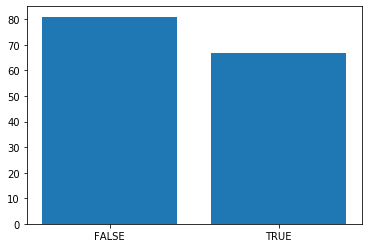

# of horrors in training set: 50
# of horrors in test set: 17
Cross-validating...
[CV]  ................................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .................................... , score=0.540, total= 2.0min
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.0min remaining:    0.0s


[CV] .................................... , score=0.592, total= 1.8min
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.8min remaining:    0.0s


[CV] .................................... , score=0.592, total= 1.9min


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  5.7min finished


Cross-validation scores: [0.54       0.59183673 0.59183673]
Mean cross-validation score: 0.575
Training model
Score on training data: 0.6036036036036037
Score on test data: 0.5405405405405406
Classification report:
              precision    recall  f1-score   support

       FALSE       0.54      1.00      0.70        20
        TRUE       0.00      0.00      0.00        17

    accuracy                           0.54        37
   macro avg       0.27      0.50      0.35        37
weighted avg       0.29      0.54      0.38        37



/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


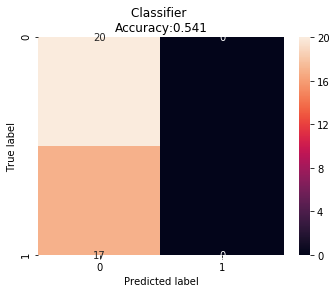

In [16]:
# explore data, fit, evaluate model
doc_train, doc_test, text_clf = fit_model()

In [17]:
# See classification results on the test set 
count_true = 0
count_false = 0
count_misclf_true = 0
count_misclf_false = 0

for document in doc_test:
    prob = text_clf.predict_proba([document['Text']])
    print(document['Title'], ", horror:", document['Horror?'],\
          ", horror probability:", prob[0][1])
    if document['Horror?'] == "TRUE":
        if prob[0][1] >= 0.5:
            count_true += 1
        else:
            count_misclf_true += 1
    else:
        if prob[0][0] >= 0.5:
            count_false += 1
        else:
            count_misclf_false += 1

print("Accuracy:", ((count_true + count_false) / len(doc_test)))
print("Correctly classfied as horror:", count_true)
print("Correctly classfied as non-horror:", count_false)
print("Misclassified as horror:", count_misclf_false)
print("Misclassified as non-horror:", count_misclf_true)

Day and Night Stories , horror: TRUE , horror probability: 0.4173346009391231
Crime and Punishment , horror: FALSE , horror probability: 0.1989016363809672
 , horror: FALSE , horror probability: 0.43843155470793804
The Willows , horror: TRUE , horror probability: 0.46250493977274004
The Works of Edgar Allan Poe: Volume 1 , horror: TRUE , horror probability: 0.42419319965534374
The Count of Monte Cristo , horror: FALSE , horror probability: 0.17242581576430058
The Brothers Karamazov , horror: FALSE , horror probability: 0.21989811664148806
The House of the Vampire , horror: FALSE , horror probability: 0.37329035022990376
The Illiad , horror: FALSE , horror probability: 0.37399559057903065
Intentions , horror: FALSE , horror probability: 0.45151440045719315
The Legend of Sleepy Hollow , horror: TRUE , horror probability: 0.46723942278155217
Vathek , horror: TRUE , horror probability: 0.37811720729431153
From Billabong to London , horror: FALSE , horror probability: 0.1730443162201314
A C

### (c) Z-Score Analysis (Heat Map)

In [18]:
num_top_words = 150
top_words = [w for w, c in all_counts.most_common(num_top_words)]

doc_word_counts = np.zeros( (len(documents), num_top_words) )

for doc_id, document in enumerate(documents):
    for word_id, word in enumerate(top_words):
        doc_word_counts[doc_id,word_id] = document["TokenCounts"][word]

doc_word_counts[:5,:10]

array([[2984., 2874., 1382., 1966., 1903., 1222.,  975.,  829.,  778.,
         492.],
       [3117., 2721., 2560., 2751., 1526., 1120., 1339., 1328.,  847.,
         736.],
       [3994., 3428., 3687., 4100., 2056., 1979., 1932., 1856., 1324.,
         897.],
       [4819., 4408., 4264., 5099., 2960., 3073., 2088., 2373., 1689.,
        1347.],
       [4204., 3446., 3692., 4153., 1946., 2049., 1832., 1837., 1500.,
        1092.]])

In [19]:
doc_lengths = doc_word_counts.sum(axis=1)
print(doc_lengths.shape)
doc_word_probs = doc_word_counts / doc_lengths[:,np.newaxis]
doc_word_probs[:5,:10]

(148,)


array([[0.07481509, 0.07205716, 0.03464962, 0.04929171, 0.04771217,
        0.03063808, 0.02444528, 0.02078476, 0.01950608, 0.01233546],
       [0.06441813, 0.05623411, 0.05290677, 0.05685411, 0.0315374 ,
        0.02314671, 0.02767272, 0.02744539, 0.0175047 , 0.0152107 ],
       [0.05650181, 0.04849479, 0.05215878, 0.05800136, 0.02908556,
        0.02799627, 0.02733137, 0.02625622, 0.01873019, 0.01268957],
       [0.05143833, 0.04705129, 0.04551422, 0.05442707, 0.03159524,
        0.03280141, 0.02228745, 0.02532956, 0.0180285 , 0.01437797],
       [0.05832247, 0.04780666, 0.05121944, 0.05761494, 0.02699703,
        0.02842596, 0.0254155 , 0.02548486, 0.02080963, 0.01514941]])

In [20]:
word_means = doc_word_probs.mean(axis=0)
word_sds = doc_word_probs.std(axis=0)

doc_word_zscores = (doc_word_probs - word_means[np.newaxis,:]) / word_sds[np.newaxis,:]  ## subtract means, divide by std
doc_word_zscores[:5,:10]

array([[-1.06154645,  1.23920776, -1.1752639 ,  0.49947176,  1.2934082 ,
        -0.19552637, -0.80522264, -0.53245319, -0.53708206, -0.71137155],
       [-1.49558363,  0.01182716, -0.02011508,  1.57051178, -1.06013825,
        -0.55854067, -0.12535873,  0.36143583, -0.87504174, -0.38835293],
       [-1.82606244, -0.58850515, -0.06744118,  1.73299255, -1.41689824,
        -0.32354274, -0.19726453,  0.20184432, -0.66810075, -0.67159   ],
       [-2.03744516, -0.70047661, -0.48784922,  1.22677678, -1.05172168,
        -0.09069674, -1.25977121,  0.0774817 , -0.78659138, -0.48190598],
       [-1.7500564 , -0.64188276, -0.12687404,  1.67826511, -1.7207941 ,
        -0.30272077, -0.60084505,  0.09832407, -0.31695949, -0.39523789]])

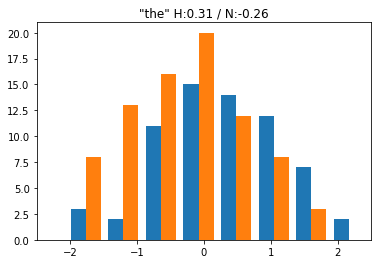

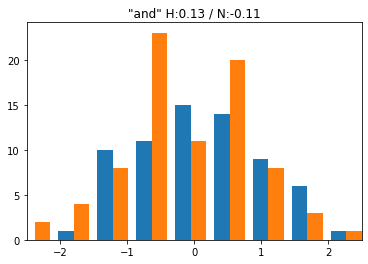

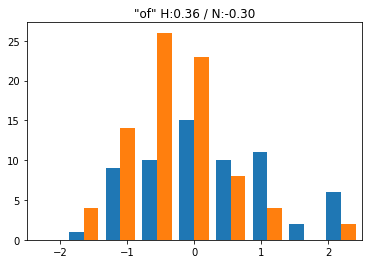

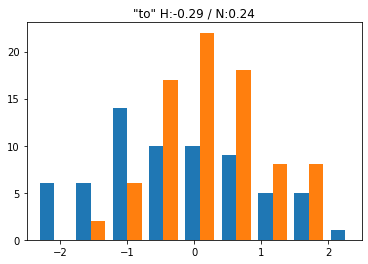

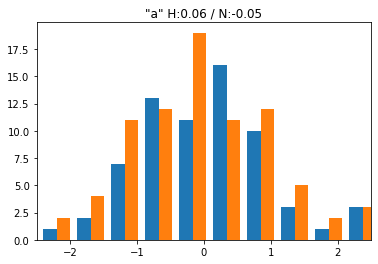

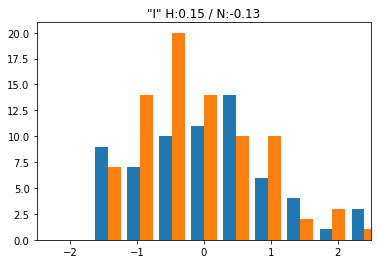

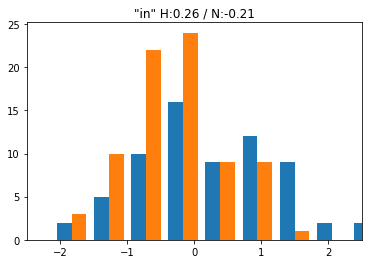

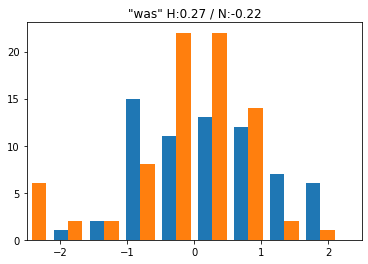

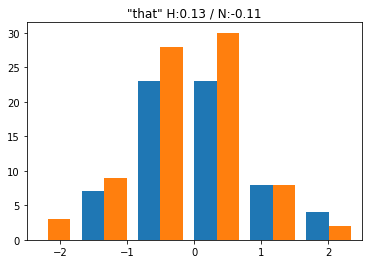

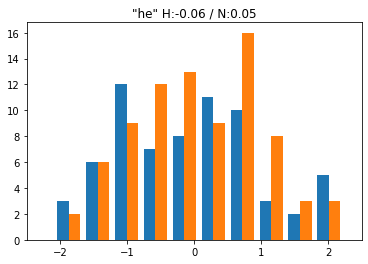

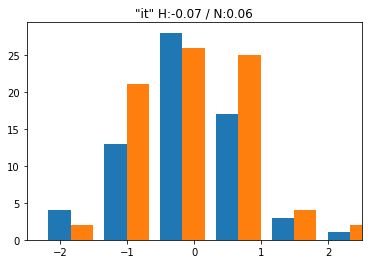

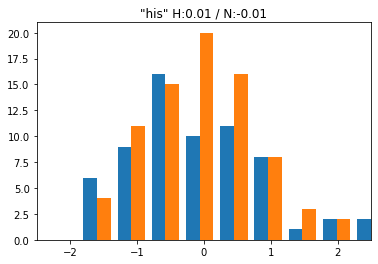

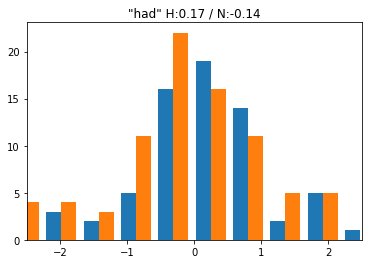

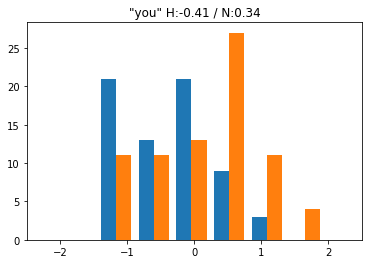

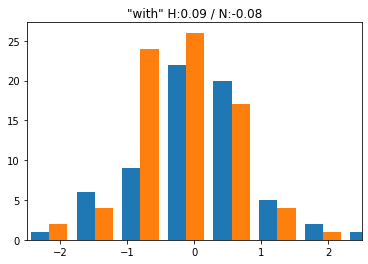

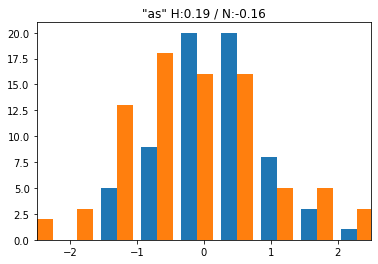

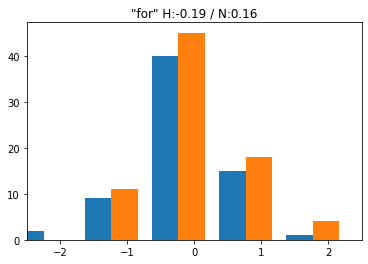

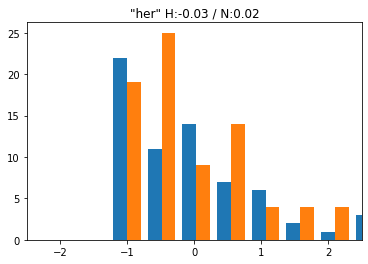

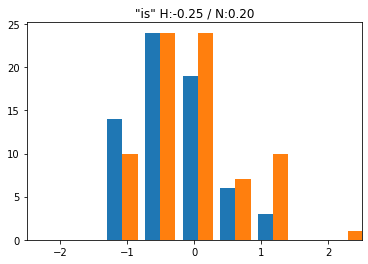

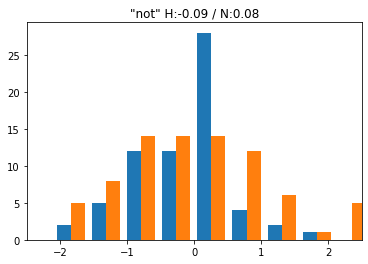

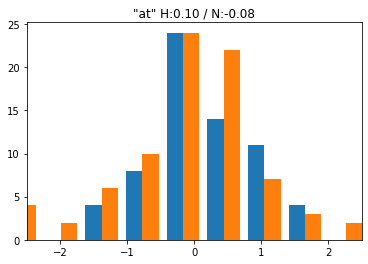

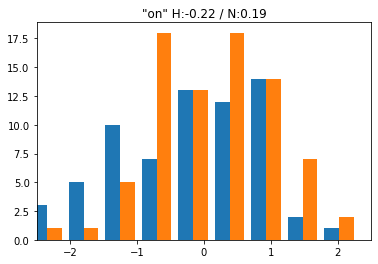

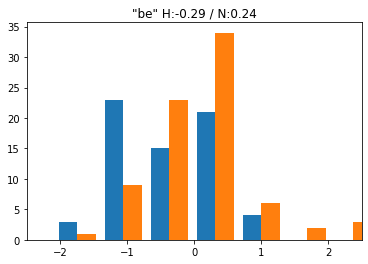

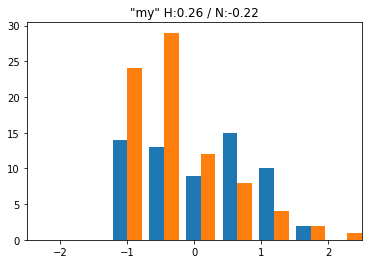

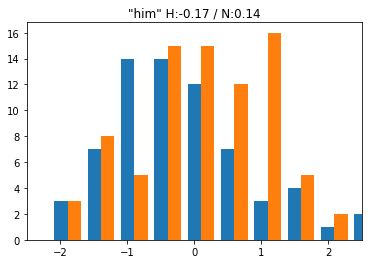

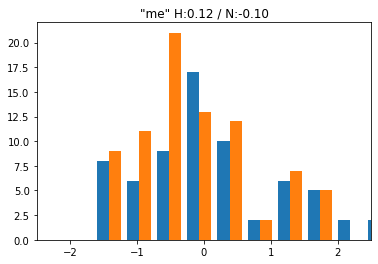

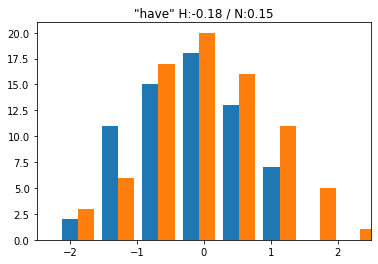

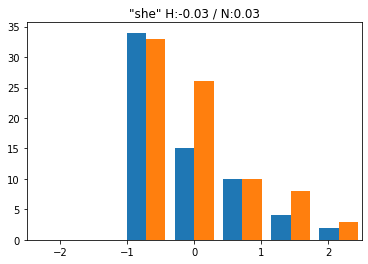

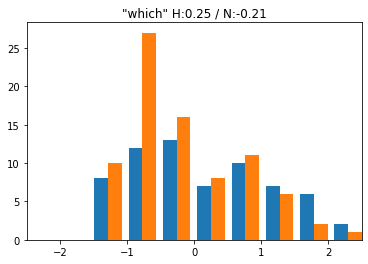

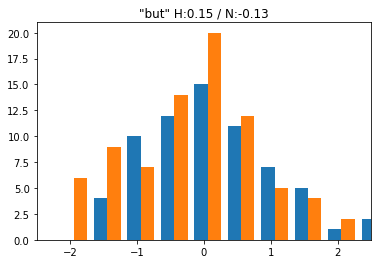

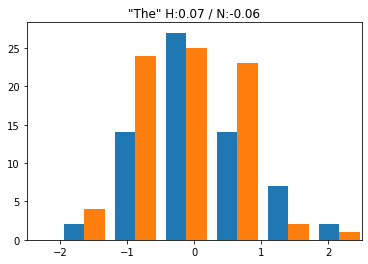

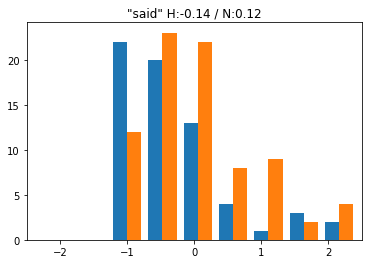

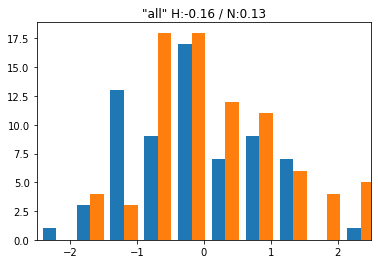

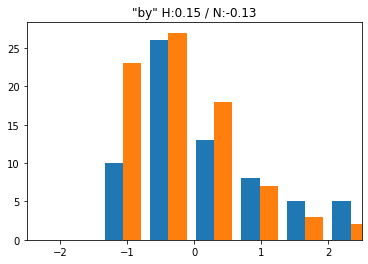

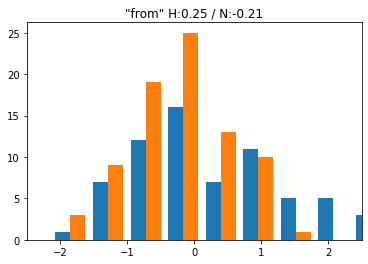

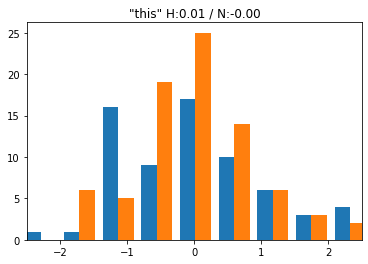

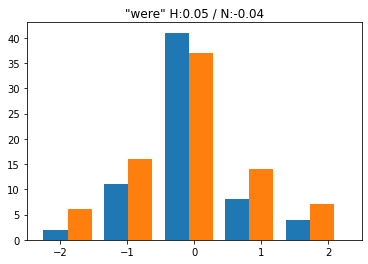

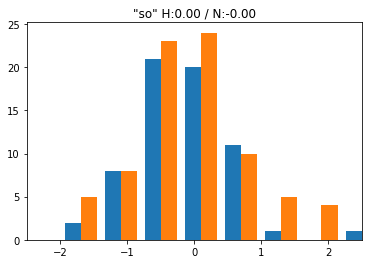

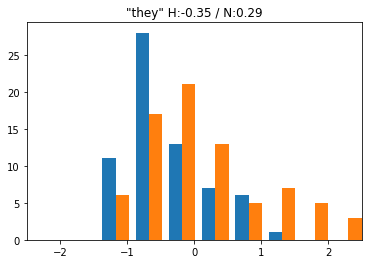

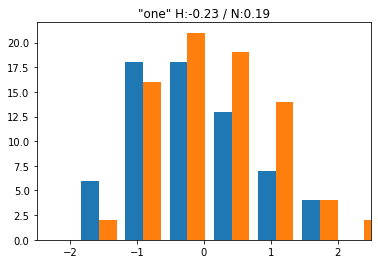

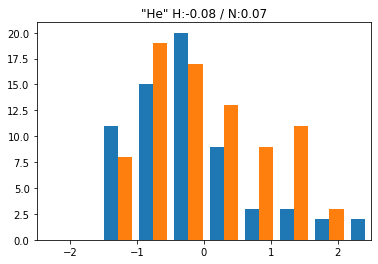

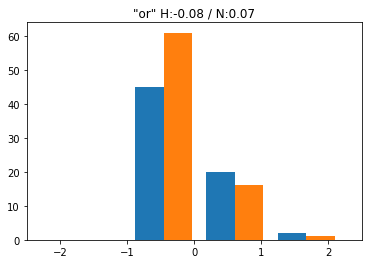

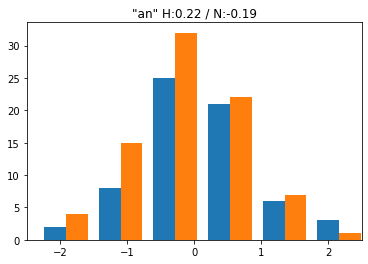

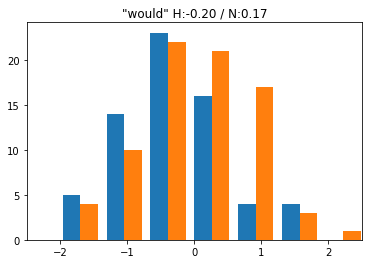

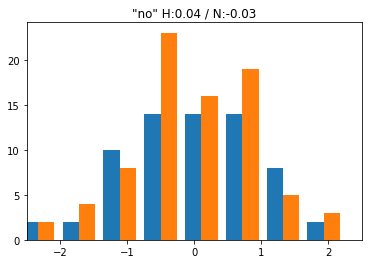

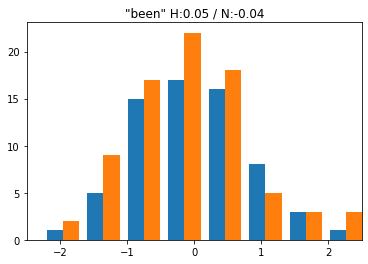

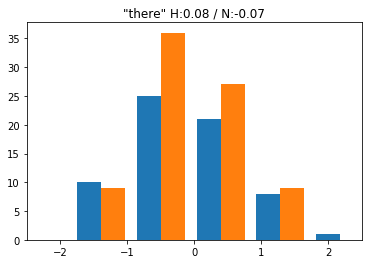

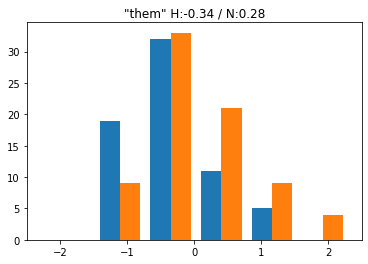

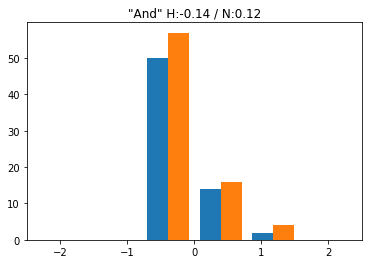

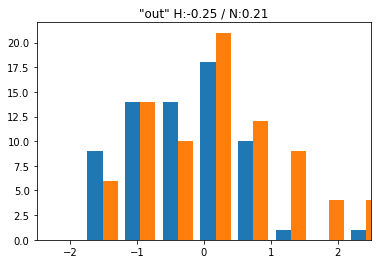

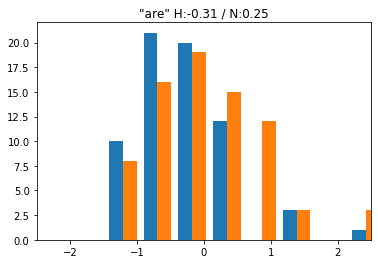

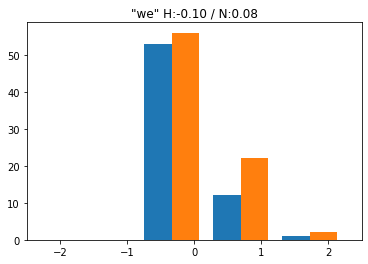

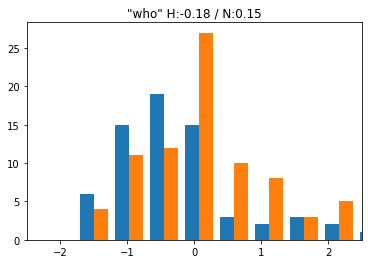

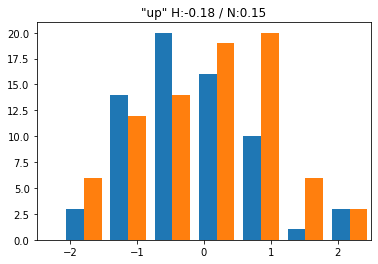

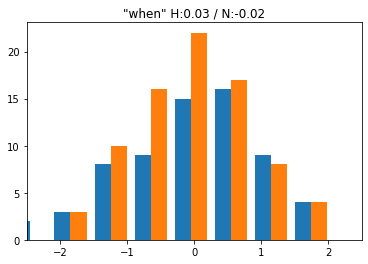

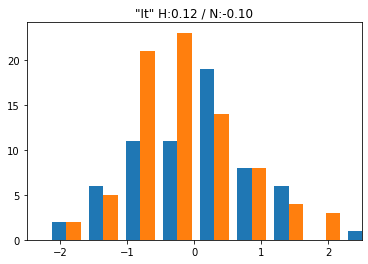

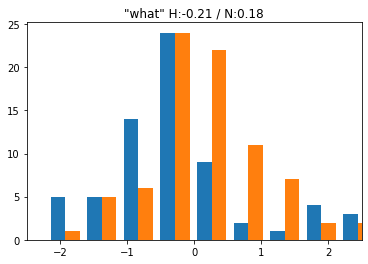

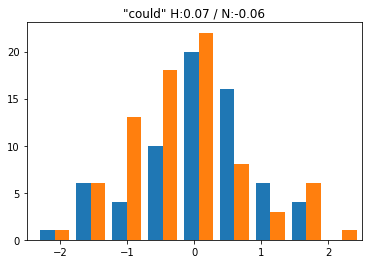

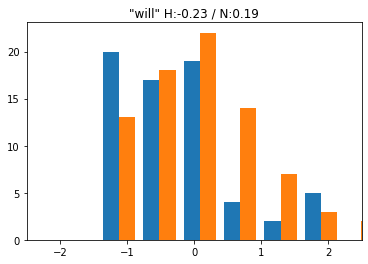

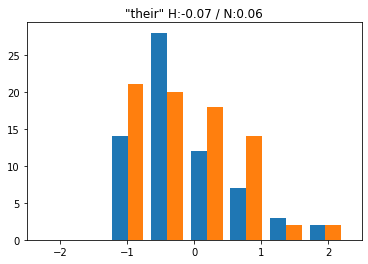

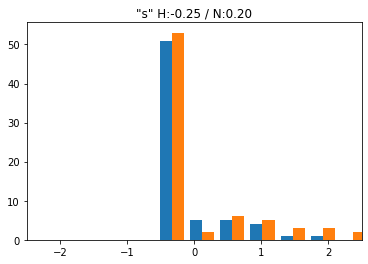

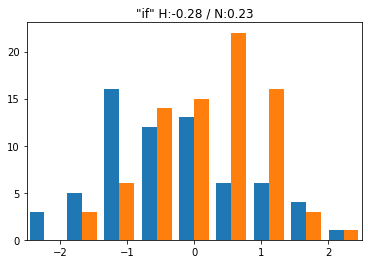

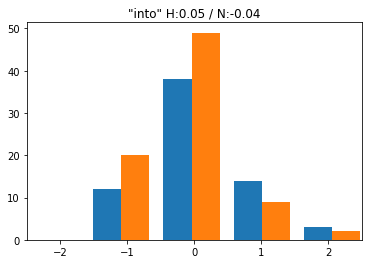

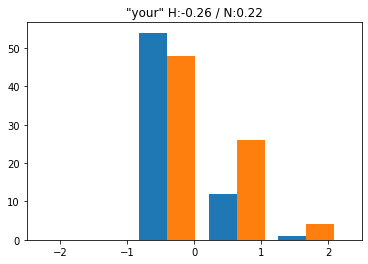

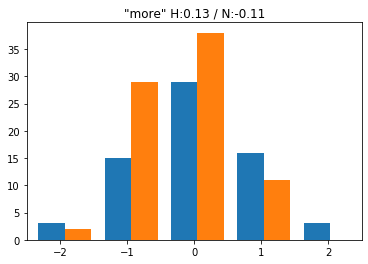

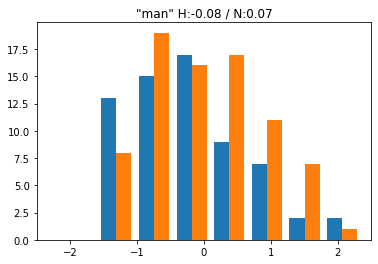

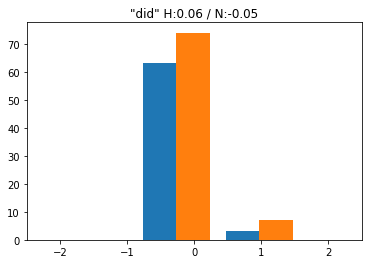

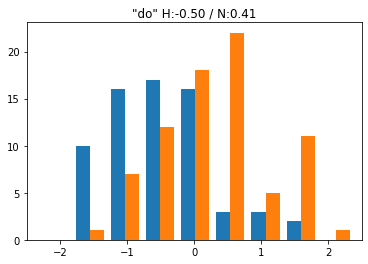

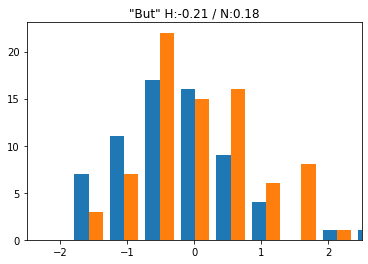

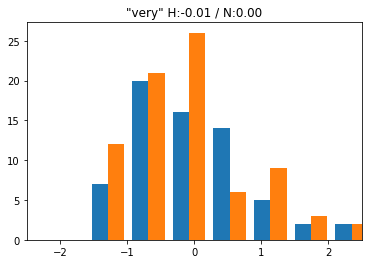

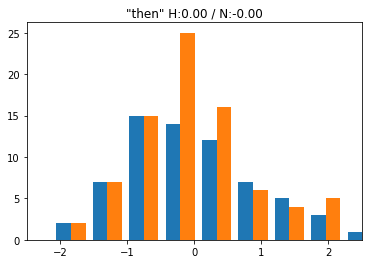

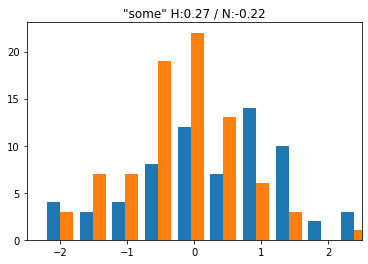

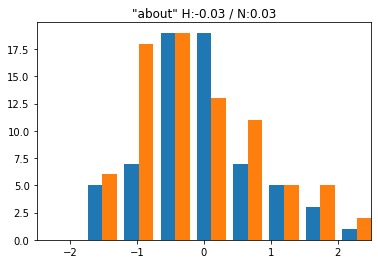

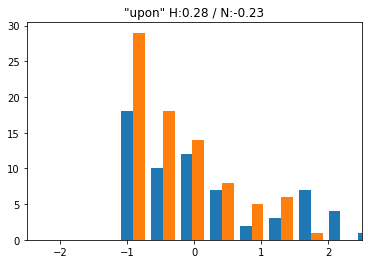

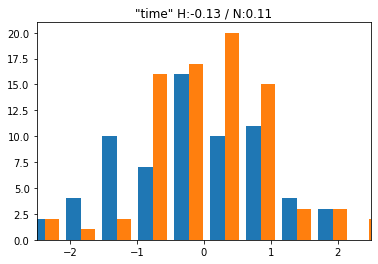

In [21]:
diff_scores = np.zeros(75)

for word_id, word in enumerate(top_words[:75]): #getting both value and position
    horror_scores = doc_word_zscores[np.array([True if i in horror_genre else False for i in genre_list]), word_id]
    nonhorror_scores = doc_word_zscores[np.array([False if i in horror_genre else True for i in genre_list]), word_id]
    
    diff_scores[word_id] = np.abs(np.mean(horror_scores) - np.mean(nonhorror_scores))
    
    plt.xlim(-2.5, 2.5) #Blue color is horror and Orange color is non-horror
    plt.title("\"{}\" H:{:.2f} / N:{:.2f}".format(word, np.mean(horror_scores), np.mean(nonhorror_scores)))
    plt.hist([horror_scores, nonhorror_scores], 10, histtype='bar')
    plt.show()

In [22]:
diff_scores = np.zeros(len(top_words))

for word_id, word in enumerate(top_words): #getting both value and position
    horror_scores = doc_word_zscores[np.array([True if i in horror_genre else False for i in genre_list]), word_id]
    nonhorror_scores = doc_word_zscores[np.array([False if i in horror_genre else True for i in genre_list]), word_id]
    
    diff_scores[word_id] = np.abs(np.mean(horror_scores) - np.mean(nonhorror_scores))

In [23]:
diff_idx = np.where(diff_scores > 0.5)[0]
diff_words = [top_words[i] for i in diff_idx]

print("Different Word Usage Between Horror and Non-horror:", diff_words)

Different Word Usage Between Horror and Non-horror: ['the', 'of', 'to', 'you', 'be', 'they', 'them', 'are', 'if', 'do', 'upon', 'know', 'You', 'can', 'its', 'say', 'go', 'good', 'here', 'What', 'through', 'saw', 'make', 'They']


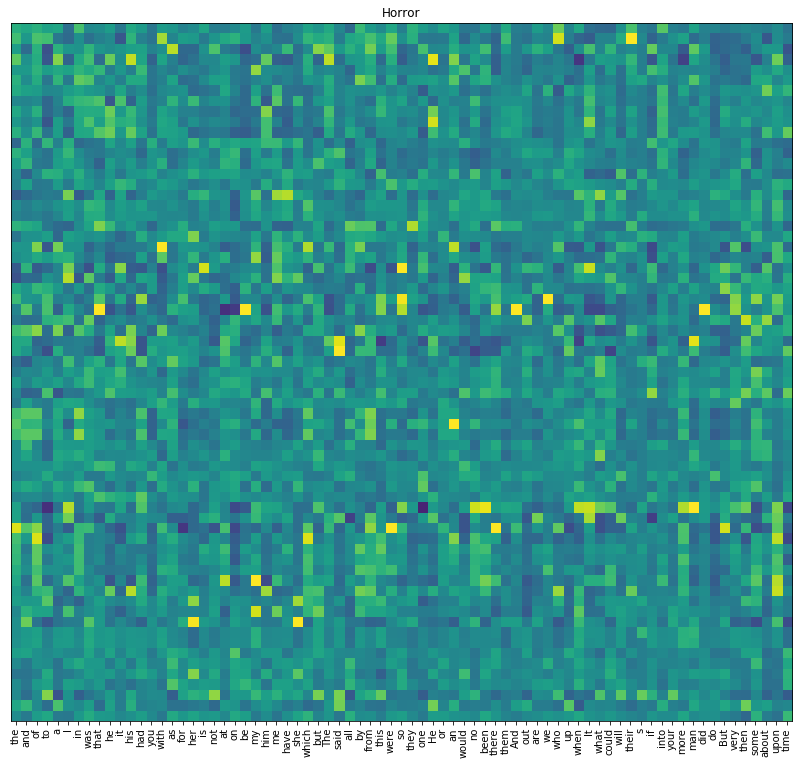

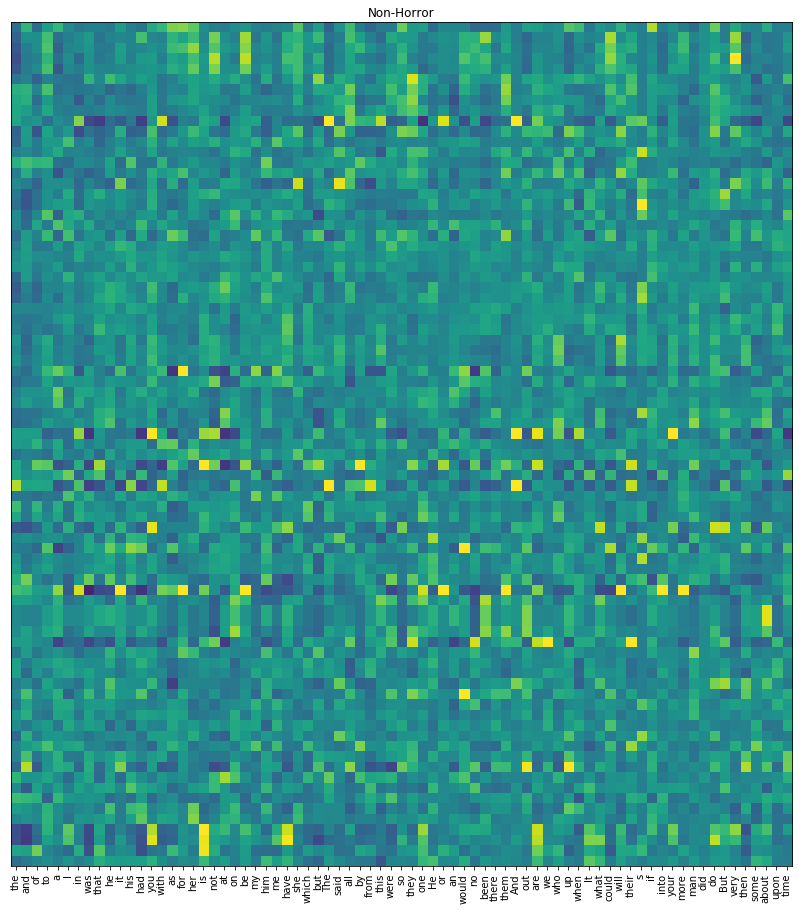

In [24]:
genre_list = np.array([doc["Genre"] for doc in documents])

plt.figure(figsize=(14, 24))
plt.title("Horror")
plt.yticks([])
plt.xticks(range(75), top_words[:75], rotation="vertical")
plt.imshow(doc_word_zscores[np.array([True if i in horror_genre else False for i in genre_list]),:75], vmin=-4, vmax=4)
plt.show()

plt.figure(figsize=(14, 24))
plt.title("Non-Horror")
plt.yticks([])
plt.xticks(range(75), top_words[:75], rotation="vertical")
plt.imshow(doc_word_zscores[np.array([False if i in horror_genre else True for i in genre_list]),:75], vmin=-4, vmax=4)
plt.show()

## 4. Results

### (a) Cosine Similarity

First, we check the nearest 5 documents in terms of cosine similarity, and the result suggests that average of cosine similarities of 5 printed documents for each horror documents are high(above 0.9); those 5 documents are considered to he similar to the query document with respect to the distribution of words. Then, we calculate the accuracy according to the method described above, and the result shows the accuracy of approximately 73%. Documents that lowered the accuracy by having non-horror documents in a group with high cosine similarity are the following: The Castle of Otranto, The Cask of Amontillado, The Man, The Sorcery Club, The Turn of the Screw, Life Blood, Wuthering Heights.

We execute the same process for bottom five documents with low cosine similarity (ranging from 0.5 to -0.8). For the accuracy, the result presents the value of roughly 98%; this implies cosine similarity anlaysis correctly identifies non-horror documents to have low cosine similarity when the input of the function is horror. There is only one document that negatively impacted the accuracy: The Yellow Wallpaper.

### (b) Supervised Learning (Naive Bayes, Logistic Regression)

First, notice that 3-fold cross validation scores are 0.54, 0.59183673, and 0.59183673 which correspond to 55~60% accuracy. Here, we obtain test accuracy of 54%. Running the code multiple times, however, the test accuracies vary from 48% to 77% depending on the training data since we are randomly selecting training data and the remaining texts as test data. The accuracy is low when most of novels are uniformly classified horror or non-horrors. This is evident from the confusion matrix; when the accuracy is low, we see that the lower left corner is brighter such that multiple horror novels are misclassified as non-horror while non-horrors documents were correctly classified.

Second, it should be noted that we can return probabilities for each label since we are using logistic regression. For horror texts, the range of probabilities is moderate with the values of 0.35~0.5. In other words, we know that there are no exact "horror" classifications with high probabilities. Rather, the algorithm is more suited to classifiying which texts are non-horrors compared to horrors, which indicates distinctive non-horror features *with respect to* horror documents.

### (c) Z-Score Analysis (Heatmap) 

The list of historgam plots show z scores of a particular word in horror (in blue) and non-horror (in orange) texts on the x axis and the frequency of scores on the y axis of the plot. Each histogram plot's title also shows the average z score of that particular word in both horror (H) and non-horror (N) texts. In question 1, we hypothesized that frequently used words like "the", "of", "a", "he", "she" to now show much disparity in usage of words between the two genres. Based on the respective scores of those words calculated and visuzlied in the histrogram plots, words "a" (mean z score difference of 0.11), "he" (0.11), and "she" (0.06) did confirm our hypothesis with small difference. However, z scores for the words "the" (Horror: 0.31 / Non-Horror: -0.26) and "of" (Horror: 0.36 / Non-Horror: -0.3)  show that they are used more in texts in horror genre compared non-horror genre. With significant differences in mean z score for words "the" (0.61) and "of" (0.66) between the horror and non-horror genres, this rejects my hypothesis about these words. In question 1, we also hypothesized that words like "upon", "do", and "it" are more used in horror texts than non-horror texts. Based on the respective scores of those words calculated and visualized in the histogram plots, the results show that the word "upon" (Horror: 0.28 / Non-Horror: -0.23) is used more in horror texts than non-horror texts while the word "do" is used more in non-horror texts than horror texts to a noticeable extent (mean z score difference of 0.51 and 0.9 for words "upon" and "do", respectively). The results also show that the word "it" doesn't vary much in usage between horror and non-horror texts with mean z score difference of 0.12. The results confirms our hypothesis for the word "upon" being more prevalent in use in horror texts than non-horro texts. However, the results reject our hypothesis for words "do", which is actually used more in non-horror texts than horror texts, and "it", which doesn't vary much in usage between the two genres.

The heat maps show distribution of z scores for each word (limited to top 75 words) across every document in horror and non-horror texts in the collection. For each box, the colors in brighter spectrum (closer to yellow) means high usage of the word (high z score) while the colors in darker spectrum (close to navy) means low usage of the word (low z score). With the long list of documents, the heat map is not as legible as it could be but there are still some differences you can notice in the heat maps that distinguish the horror and non-horror texts based on the usage of words (z scores). Looking at the boxes for words "upon", "the", and "of", it can be observed how the general color pattern in "Horror" heat map is brighter than in "Non-Horror" heat map, which signifies that these words are used morein horror texts than non-horror texts. 

## 5. Reflections

In customizing metadata for our analysis, we decided to use "Horror?" column instead of "Genre" column because we noticed some issues in "Genre" column that may decrease the accuracy of our analysis. Some documents are considered to have multiple genres separated with ";" (e.g. Four Weird Tales, Horror;Supernatural), and those documents will not be captured if we simply use the if statement "if document["Genre"] == "Horror" in distinguising horror from non-horror documents. Moreover, for some horror documents, there is an extra space after "Horror" in "Genre" column, and this minor mistake may have a negative effect on our analysis as "Horror " will not yield True for the if statement "if document["Genre"] == "Horror".

We believe that the accuracy of cosine similarity is decreased due to the fact that cosine similarity takes individual words into account rather than the actual context. Therefore, the result of clustering horror document with majority of non-horror documents is plausible if distribution of individual words of the horror document is closer to that of non-horror document although the context itself suggests otherwise. For example, 5 documents with high cosine similarity with regards to "The Cask of Amontillado" are mostly non-horror, and we can reason this result by claiming that the genre of "The Cask of Amontillado" is subtle(Gothic/Horror), and the document itself is a short story, and therefore it is not appropriate to use cosine similarity that measures distribution of individual words. Then, we tried to establish the boundary between horrors and non-horrors via supervised  learning with two well-known classifiers$-$Naive Bayes and logistic regression. 

The limitation of supervised learning is the problem of overfitting and underfitting. As mentioned above, finer hyperparemeter tuning using grid search may be not useful in text analysis. Since the total vocalubary set is local to the training data, tuning classifier parameters may cause overfitting or underfitting problem and yield bias among horrors and non-horrors. This further explains the variability of accuracy that significantly depends on the training set. 

Intuitively, suppose we have a series of three horror books in our data. If two of three books are included in the training set, it is very likely that the remaining one will be classified horror. Now suppose that no books were included in the training set, the probability of being horror for each book will be much lower than that of the previous case (i.e., underrepresented). The correct classficitions and misclassifications both highly depend on the whole dictionary, so we may conclude that the naive application of two classifiers on whole corpus is not enough to distinguish between horrors and non-horrors. 

Note that the compile time for supervised learning is relatively long (~10 minutes) and we limit the scope to the material that we covered in class. There are other features that can be layered to our model, but we leave them open to future considerations. From first two methods, however, we confirmed that horror documents have different characteristics that are discernible from non-horror documents.

With the help of Z-score analysis, we were able to find a set of words that are more prevalent in either the texts in horror or non-horror genre. However, in the process of performing the analysis, we learned that there are some limitations with this method. One of the limitations with the method we used is that the Z-scores for a particular word lack consistency across documents within the same genre (horror vs non-horror). This potentially leads to unreliable results and makes heat map visualization difficult to read and distinguish the difference in Z-scores via general color pattern. Another limitation with the method we used is the possible effect of outliers among documents that significantly skew the histrogram results for the genre that it's associated with. This could potentially produce misleading results and insights that aren't actually useful for classifying horror and non-horror texts.

## 6. Responsibilities

We all contributed to brainstorming on what we want to learn about horror/non-horror texts, forming hypothesis based on our objective, and discussing what methods we want to use to classify horror and non-horror texts. We then scheduled team meetings to share results of our findings and cross-validate each methodology. Then, we collaboratively wrote the reflection portion.

### Citations 

[0] https://github.com/clairempr/spooky-classify/blob/master/spooky_classify.py

[1] https://towardsdatascience.com/ensemble-learning-in-machine-learning-getting-started-4ed85eb38e00

[2] https://medium.com/@makcedward/nlp-pipeline-lemmatization-part-3-4bfd7304957
